## The Final Model

My goal for this project was to develop a model of presidential election votes based on ad money spent by either side. I realized that with the difference model, the Electoral College would behave exactly as expected, but the popular vote would just degrade down to ``campaign in whatever state you want. It doesn't matter'' and that doesn't make any sense to me.

After significant thinking and chats with Claude, I came up with a new model.

Rather than fitting a Beta distribution on the change from previous years I chose to fit a Beta distribution per state for the actual turnout on a scale of $0$ (total Republican victory) to $1$ (total Democrat victory)

For a given state $s$, the parameters for the PDF were given by:

\begin{align}
a_s &= \frac{g(D_s)}{N_s} + p_{D,s} \\
b_s &= \frac{h(R_s)}{N_s} + p_{R,s}
\end{align}

Where 

- $D_s$: amount of money invested in the state by Democrats

- $R_s$: amount of money invested in the state by Republicans

- $N_s$: state's inverse distance weighted average (distance = number of elections away) of number of Partisan (Republican or Democrat) voters

- $p_{D,s}$: state's historical Democratic advantage

- $p_{R,s}$: state's historical Republican advantage

I defined advantage by

\begin{align}
p_{D,s} &= k \cdot \pi_s \\
p_{R,s} &= k \cdot (1 - \pi_s)
\end{align}

where $\pi_s$ is the weighted democratic average over the past 3 years and $k$ is a variable parameter that determines how much states stick to their history with high values representing lower elasticity

The spending functions $g$ and $h$ consistent across all states are linear, satisfy $g(0) = h(0) = 0$, and are monotonically increasing

## Fitting the model

Using a standard minimizer for various initial starting conditions and many different values for K I found the optimal parameter $k$ and representation for $g$ and $h$


SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS (LOG BASIS)

Trying k_baseline = 50...
  Best Neg Log-Likelihood: -55.7814 (from 50 random starts)

Trying k_baseline = 100...
  Best Neg Log-Likelihood: -70.7453 (from 50 random starts)

Trying k_baseline = 150...
  Best Neg Log-Likelihood: -68.9222 (from 50 random starts)

Trying k_baseline = 200...
  Best Neg Log-Likelihood: -70.7350 (from 50 random starts)

Trying k_baseline = 300...
  Best Neg Log-Likelihood: -72.6238 (from 50 random starts)

Trying k_baseline = 500...
  Best Neg Log-Likelihood: -72.6050 (from 50 random starts)

Trying k_baseline = 750...
  Best Neg Log-Likelihood: -58.5056 (from 50 random starts)

Trying k_baseline = 1000...
  Best Neg Log-Likelihood: -44.5929 (from 50 random starts)

Trying k_baseline = 1500...
  Best Neg Log-Likelihood: -10.4561 (from 50 random starts)

Trying k_baseline = 2000...
  Best Neg Log-Likelihood: 22.6882 (from 50 random starts)

Trying k_baseline = 2500...
  Best Neg Log

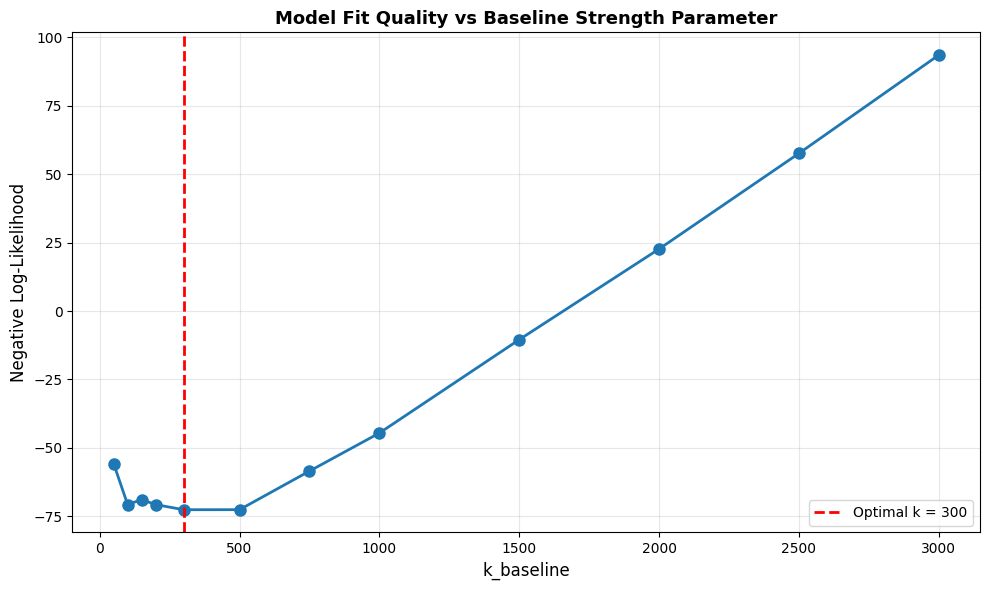

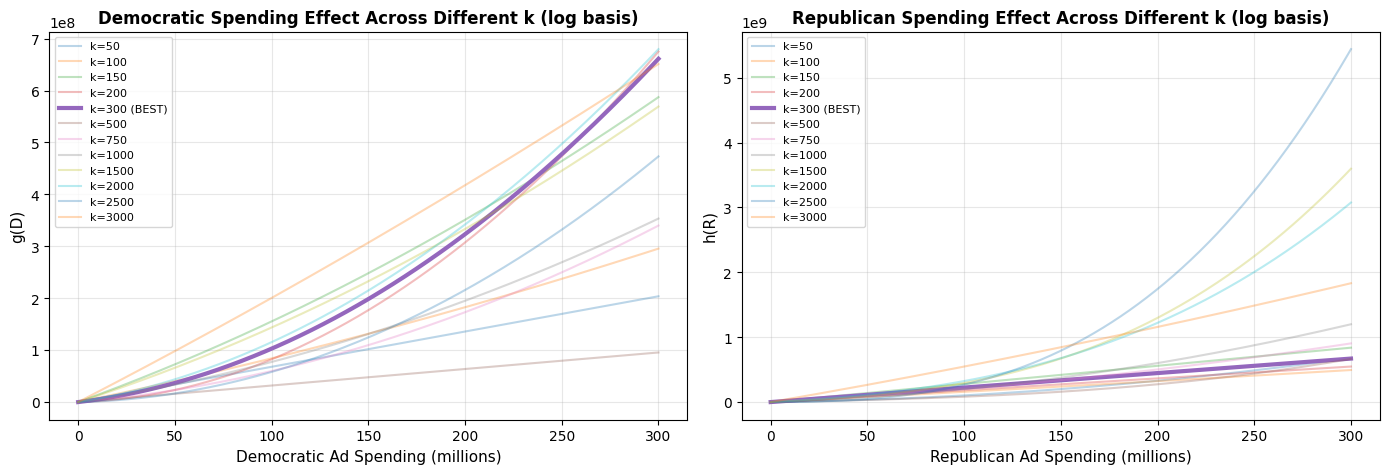


FINAL FIT WITH OPTIMAL k (LOG BASIS)

Democratic spending effect g(D):
  g1   = 441207.12553006096
  g2   = 5875.9606649492525
  g3   = 0.0
  g4   = 7835.523314781483

Republican spending effect h(R):
  h1   = 2234844.827794715
  h2   = 0.0
  h3   = 0.0
  h4   = 5980.205018952697

Optimal k_baseline = 300
Final neg log-likelihood: -72.6238

Model fit:
  Mean absolute error: 0.0299
  RMSE: 0.0346

PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS (LOG BASIS)


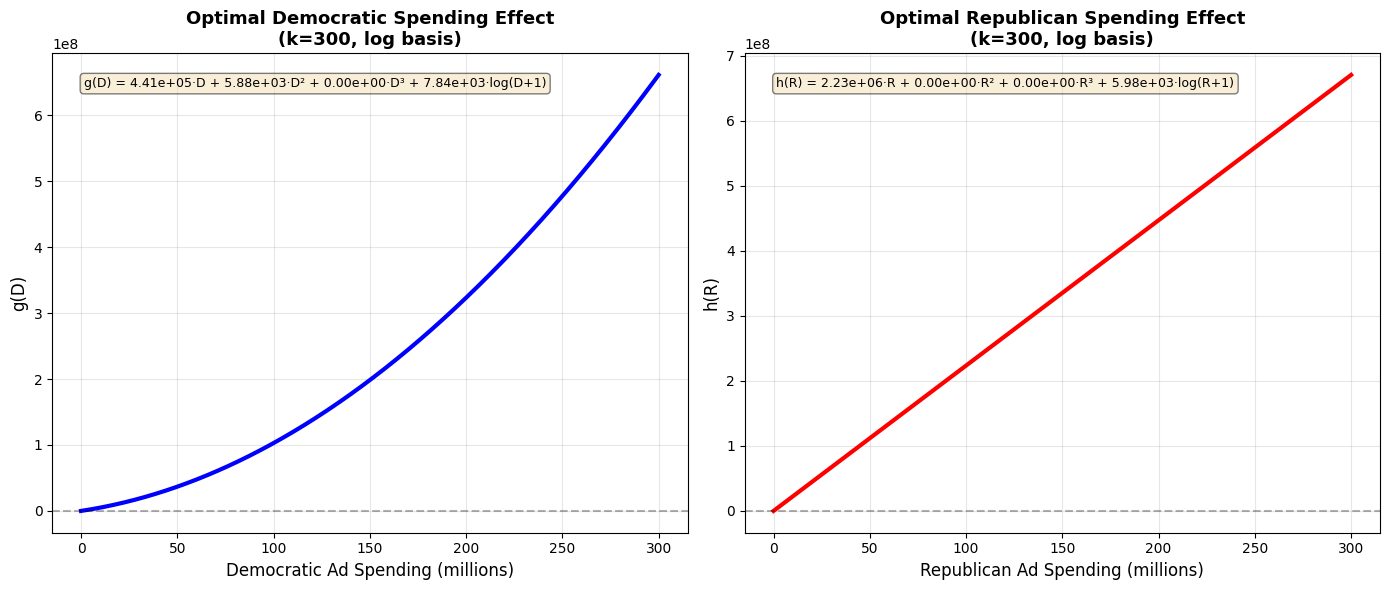

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# --- Calculate Democratic Vote Share by State and Year ---
state_partisan_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()

state_partisan_votes['DEM_SHARE'] = state_partisan_votes['DEMOCRAT'] / (
    state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN'])
state_partisan_votes['total_partisan'] = state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN']
state_partisan_votes = state_partisan_votes.sort_values(['state', 'year']).reset_index(drop=True)

# Calculate weighted 3-year prior Democratic share (baseline partisan lean)
def past_3_inverse_weights(series):
    s = series.shift(1)
    values = np.full(series.shape[0], np.nan)
    weights = np.array([1, 1/2, 1/3])
    for i in range(3, len(s)+1):
        window = s.iloc[i-3:i].values
        if np.isnan(window).any():
            continue
        weighted_avg = np.dot(window, weights) / np.sum(weights)
        values[i-1] = weighted_avg
    return pd.Series(values, index=series.index)

state_partisan_votes['Baseline_DEM_SHARE'] = (
    state_partisan_votes.groupby('state')['DEM_SHARE'].transform(past_3_inverse_weights)
)

# Calculate weighted 3-year prior total partisan votes (baseline turnout)
state_partisan_votes['Baseline_total_partisan'] = (
    state_partisan_votes.groupby('state')['total_partisan'].transform(past_3_inverse_weights)
)

# Standardize state names
state_partisan_votes['state'] = state_partisan_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge with ad spending
combined_data = ad_df.merge(
    state_partisan_votes[['year', 'state', 'total_partisan', 'DEM_SHARE', 'Baseline_DEM_SHARE', 'Baseline_total_partisan']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)

# Filter out Iowa 2016
combined_data = combined_data[~((combined_data['State'] == 'IOWA') & (combined_data['year'] == 2016))]
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'DEM_SHARE', 'total_partisan', 'Baseline_DEM_SHARE', 'Baseline_total_partisan'])

eps = 1e-7

# === Define model functions with log basis ===
def g(D, g1, g2, g3, g4):
    """Democratic spending effect with log basis - g(0)=0"""
    # Add safe log to avoid log(0)
    return g1 * D + g2 * D**2 + g3 * D**3 + g4 * np.log(D + 1)

def h(R, h1, h2, h3, h4):
    """Republican spending effect with log basis - h(0)=0"""
    return h1 * R + h2 * R**2 + h3 * R**3 + h4 * np.log(R + 1)

def neg_log_likelihood(params, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed):
    """Negative log-likelihood for optimization - NOW USES BASELINE TURNOUT"""
    g1, g2, g3, g4 = params[0:4]
    h1, h2, h3, h4 = params[4:8]
    
    if np.any(np.array([g1, g2, g3, g4, h1, h2, h3, h4]) < 0):
        return 1e12
    
    g_vals = g(D_spending, g1, g2, g3, g4)
    h_vals = h(R_spending, h1, h2, h3, h4)
    
    # Use baseline_total_partisan instead of actual total_partisan
    a_vals = (1.0 / baseline_total_partisan) * g_vals + p_D_fixed
    b_vals = (1.0 / baseline_total_partisan) * h_vals + p_R_fixed
    
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12
    
    ll = np.sum(beta.logpdf(dem_share_clipped, a_vals, b_vals))
    return -ll

# Initial parameters and bounds (add log basis term for both parties)
initial_params = np.array([5e5, 1e3, 10, 100, 5e5, 1e3, 10, 100])

bounds = [
    (0, None), (0, None), (0, None), (0, None),  # g1, g2, g3, g4
    (0, None), (0, None), (0, None), (0, None),  # h1, h2, h3, h4
]

# === PARAMETER SEARCH FOR OPTIMAL k_baseline ===
print("\n" + "="*80)
print("SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS (LOG BASIS)")
print("="*80)

k_values = [50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]
results_by_k = []

n_random_starts = 50  # Try 50 different random initializations per k

for k_baseline in k_values:
    print(f"\nTrying k_baseline = {k_baseline}...")
    
    combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
    combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])
    
    D_spending = combined_data['D-ad-spending'].values
    R_spending = combined_data['R-ad-spending'].values
    dem_share = combined_data['DEM_SHARE'].values
    baseline_total_partisan = combined_data['Baseline_total_partisan'].values  # CHANGED
    p_D_fixed = combined_data['p_D'].values
    p_R_fixed = combined_data['p_R'].values
    dem_share_clipped = np.clip(dem_share, eps, 1 - eps)
    
    best_nll = np.inf
    best_params_for_k = None
    best_success = False
    
    # Try multiple random initializations (now with 4 params per side)
    for i in range(n_random_starts):
        random_init = np.array([
            np.random.uniform(1e4, 1e7),  # g1
            np.random.uniform(0, 1e4),    # g2
            np.random.uniform(0, 1e3),    # g3
            np.random.uniform(0, 1e4),    # g4 (log)
            np.random.uniform(1e4, 1e7),  # h1
            np.random.uniform(0, 1e4),    # h2
            np.random.uniform(0, 1e3),    # h3
            np.random.uniform(0, 1e4),    # h4 (log)
        ])
        
        result_k = minimize(
            lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
            random_init, bounds=bounds, method='L-BFGS-B', options={'maxiter': 1300, 'ftol': 1e-8}
        )
        
        if result_k.success and result_k.fun < best_nll:
            best_nll = result_k.fun
            best_params_for_k = result_k.x.copy()
            best_success = True
    
    results_by_k.append({
        'k_baseline': k_baseline,
        'neg_log_likelihood': best_nll,
        'success': best_success,
        'params': best_params_for_k
    })
    
    print(f"  Best Neg Log-Likelihood: {best_nll:.4f} (from {n_random_starts} random starts)")

# Find best k
results_df = pd.DataFrame(results_by_k)
best_idx = results_df['neg_log_likelihood'].idxmin()
best_k = results_df.loc[best_idx, 'k_baseline']
best_params = results_df.loc[best_idx, 'params']

print("\n" + "="*80)
print("k_baseline SEARCH RESULTS")
print("="*80)
print(results_df[['k_baseline', 'neg_log_likelihood', 'success']].to_string(index=False))
print(f"\nOPTIMAL k_baseline = {best_k}")

# Plot likelihood vs k
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(results_df['k_baseline'], results_df['neg_log_likelihood'], 'o-', lw=2, markersize=8)
ax.axvline(best_k, color='r', linestyle='--', lw=2, label=f'Optimal k = {best_k}')
ax.set_xlabel('k_baseline', fontsize=12)
ax.set_ylabel('Negative Log-Likelihood', fontsize=12)
ax.set_title('Model Fit Quality vs Baseline Strength Parameter', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot spending effect curves for different k values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

D_range_viz = np.linspace(0, 300, 200)  # 0 to 300M spending
R_range_viz = np.linspace(0, 300, 200)

for i, row in results_df.iterrows():
    if row['success'] and row['params'] is not None:
        k_val = row['k_baseline']
        params = row['params']
        g1, g2, g3, g4 = params[0:4]
        h1, h2, h3, h4 = params[4:8]
        
        g_curve = g(D_range_viz, g1, g2, g3, g4)
        h_curve = h(R_range_viz, h1, h2, h3, h4)
        
        alpha = 0.3 if k_val != best_k else 1.0
        lw = 1.5 if k_val != best_k else 3.0
        label = f'k={k_val}' + (' (BEST)' if k_val == best_k else '')
        
        axes[0].plot(D_range_viz, g_curve, alpha=alpha, lw=lw, label=label)
        axes[1].plot(R_range_viz, h_curve, alpha=alpha, lw=lw, label=label, color=f'C{i}')

axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=11)
axes[0].set_ylabel('g(D)', fontsize=11)
axes[0].set_title('Democratic Spending Effect Across Different k (log basis)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=11)
axes[1].set_ylabel('h(R)', fontsize=11)
axes[1].set_title('Republican Spending Effect Across Different k (log basis)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === FIT FINAL MODEL WITH OPTIMAL k ===
k_baseline = best_k
combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])

D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
dem_share = combined_data['DEM_SHARE'].values
baseline_total_partisan = combined_data['Baseline_total_partisan'].values  # CHANGED
p_D_fixed = combined_data['p_D'].values
p_R_fixed = combined_data['p_R'].values
dem_share_clipped = np.clip(dem_share, eps, 1 - eps)

print("\n" + "="*80)
print("FINAL FIT WITH OPTIMAL k (LOG BASIS)")
print("="*80)

result = minimize(
    lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
    best_params, bounds=bounds, method='L-BFGS-B', options={'maxiter': 2000, 'ftol': 1e-9}
)

g1_opt, g2_opt, g3_opt, g4_opt = result.x[0:4]
h1_opt, h2_opt, h3_opt, h4_opt = result.x[4:8]

print(f"\nDemocratic spending effect g(D):")
print(f"  g1   = {g1_opt}")
print(f"  g2   = {g2_opt}")
print(f"  g3   = {g3_opt}")
print(f"  g4   = {g4_opt}")

print(f"\nRepublican spending effect h(R):")
print(f"  h1   = {h1_opt}")
print(f"  h2   = {h2_opt}")
print(f"  h3   = {h3_opt}")
print(f"  h4   = {h4_opt}")

print(f"\nOptimal k_baseline = {k_baseline}")
print(f"Final neg log-likelihood: {result.fun:.4f}")

# Calculate fitted values for diagnostics
g_vals_fitted = g(D_spending, g1_opt, g2_opt, g3_opt, g4_opt)
h_vals_fitted = h(R_spending, h1_opt, h2_opt, h3_opt, h4_opt)
a_fitted = (1.0 / baseline_total_partisan) * g_vals_fitted + p_D_fixed
b_fitted = (1.0 / baseline_total_partisan) * h_vals_fitted + p_R_fixed
predicted_share = a_fitted / (a_fitted + b_fitted)

residuals = dem_share - predicted_share
print(f"\nModel fit:")
print(f"  Mean absolute error: {np.mean(np.abs(residuals)):.4f}")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")

# === PLOT FINAL OPTIMAL g(D) AND h(R) FUNCTIONS ===
print("\n" + "="*80)
print("PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS (LOG BASIS)")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

D_range_final = np.linspace(0, 300, 500)
R_range_final = np.linspace(0, 300, 500)

g_final = g(D_range_final, g1_opt, g2_opt, g3_opt, g4_opt)
h_final = h(R_range_final, h1_opt, h2_opt, h3_opt, h4_opt)

axes[0].plot(D_range_final, g_final, 'b-', lw=3)
axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=12)
axes[0].set_ylabel('g(D)', fontsize=12)
axes[0].set_title(f'Optimal Democratic Spending Effect\n(k={k_baseline}, log basis)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)

g_text = (f"g(D) = {g1_opt:.2e}·D + {g2_opt:.2e}·D² + {g3_opt:.2e}·D³ + {g4_opt:.2e}·log(D+1)")
axes[0].text(0.05, 0.95, g_text, transform=axes[0].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].plot(R_range_final, h_final, 'r-', lw=3)
axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=12)
axes[1].set_ylabel('h(R)', fontsize=12)
axes[1].set_title(f'Optimal Republican Spending Effect\n(k={k_baseline}, log basis)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)

h_text = (f"h(R) = {h1_opt:.2e}·R + {h2_opt:.2e}·R² + {h3_opt:.2e}·R³ + {h4_opt:.2e}·log(R+1)")
axes[1].text(0.05, 0.95, h_text, transform=axes[1].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

This model was essentially linear so I eliminated all other basis terms and got a simple, effective, and interpretable model


SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS

Trying k_baseline = 50...
  Best Neg Log-Likelihood: -56.4018 (from 50 random starts)

Trying k_baseline = 100...
  Best Neg Log-Likelihood: -71.7677 (from 50 random starts)

Trying k_baseline = 150...
  Best Neg Log-Likelihood: -29.6655 (from 50 random starts)

Trying k_baseline = 200...
  Best Neg Log-Likelihood: -74.2822 (from 50 random starts)

Trying k_baseline = 300...
  Best Neg Log-Likelihood: -75.6546 (from 50 random starts)

Trying k_baseline = 500...
  Best Neg Log-Likelihood: -64.4613 (from 50 random starts)

Trying k_baseline = 750...
  Best Neg Log-Likelihood: -60.7237 (from 50 random starts)

Trying k_baseline = 1000...
  Best Neg Log-Likelihood: -45.4743 (from 50 random starts)

Trying k_baseline = 1500...
  Best Neg Log-Likelihood: -13.0789 (from 50 random starts)

Trying k_baseline = 2000...
  Best Neg Log-Likelihood: 20.7512 (from 50 random starts)

Trying k_baseline = 2500...
  Best Neg Log-Likelihood:

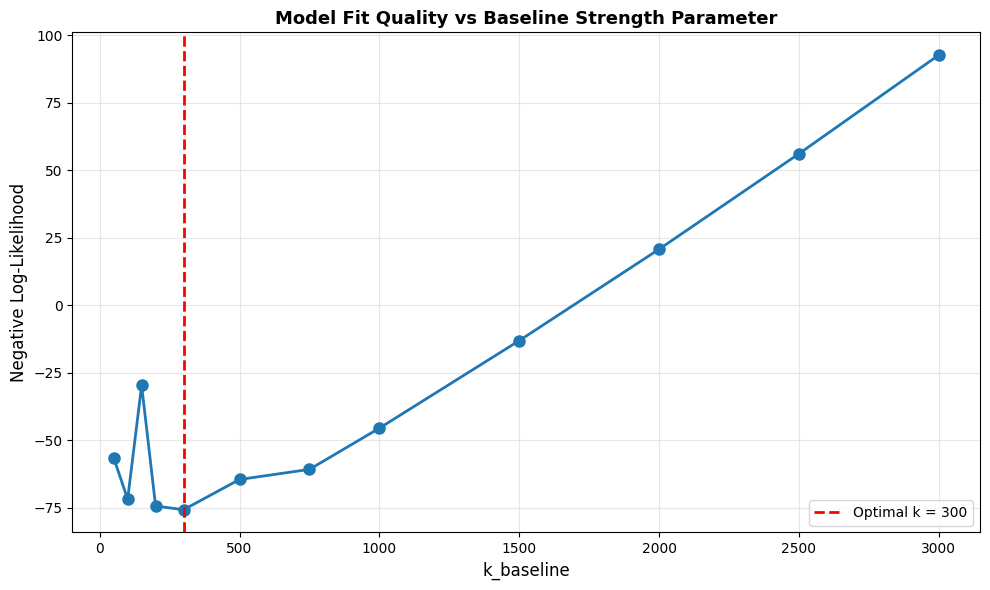

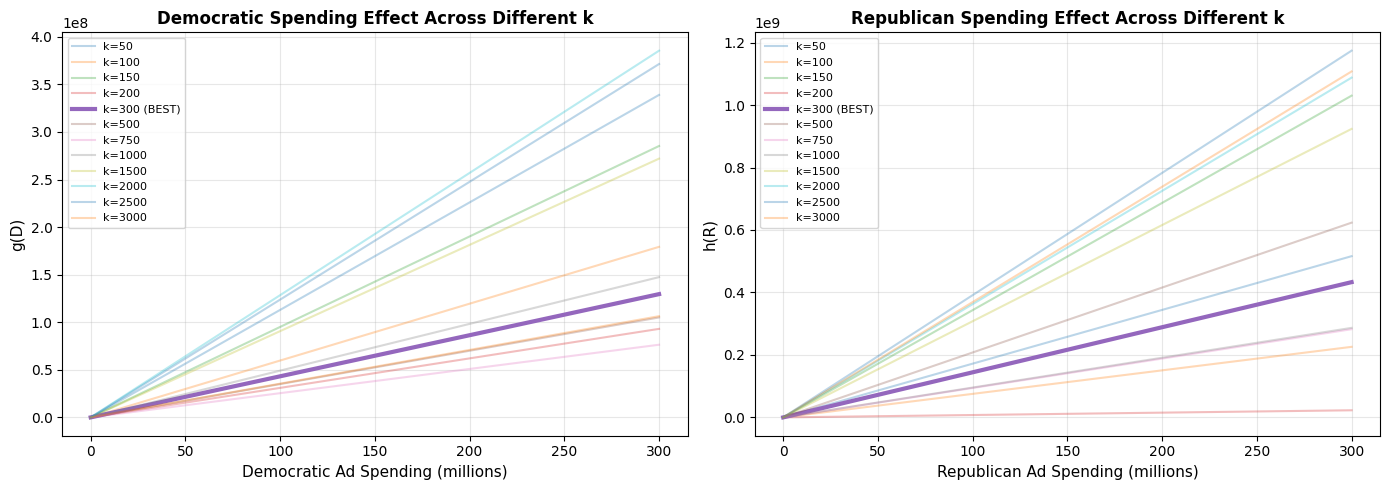


FINAL FIT WITH OPTIMAL k

Democratic spending effect g(D):
  g1   = 431845.2625892413

Republican spending effect h(R):
  h1   = 1443380.6804634784

Optimal k_baseline = 300
Final neg log-likelihood: -75.6546

Model fit:
  Mean absolute error: 0.0286
  RMSE: 0.0333

PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS


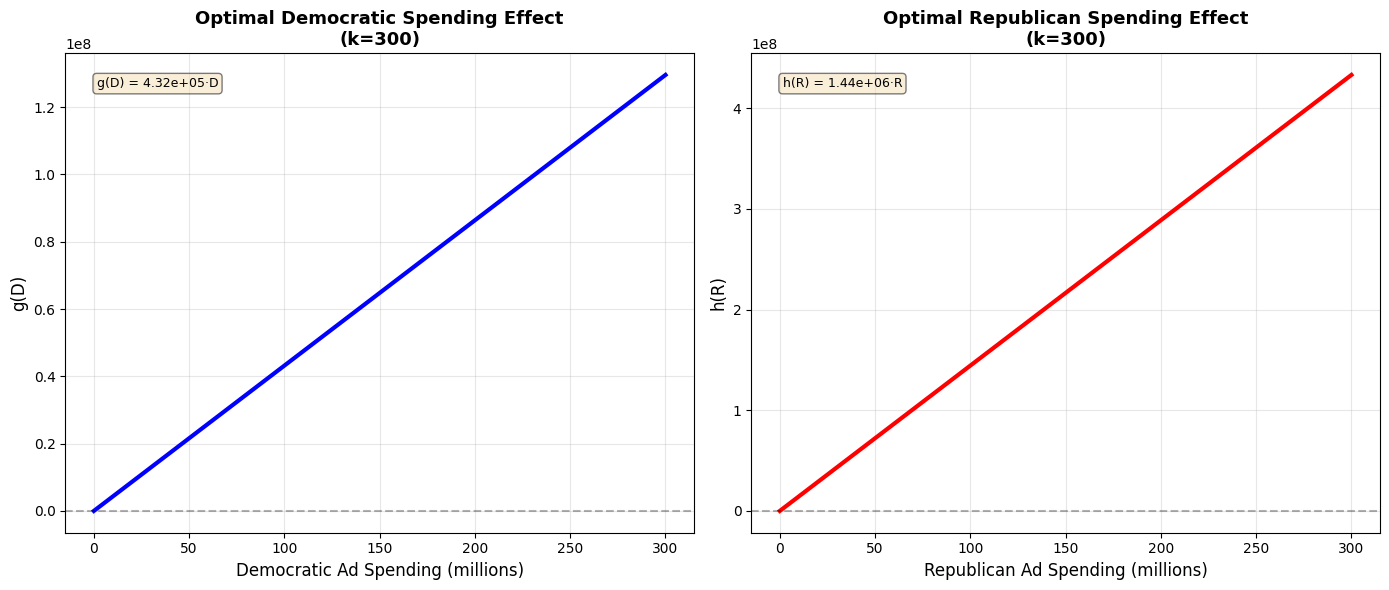


GENERATING STATE-BY-STATE BETA DISTRIBUTIONS


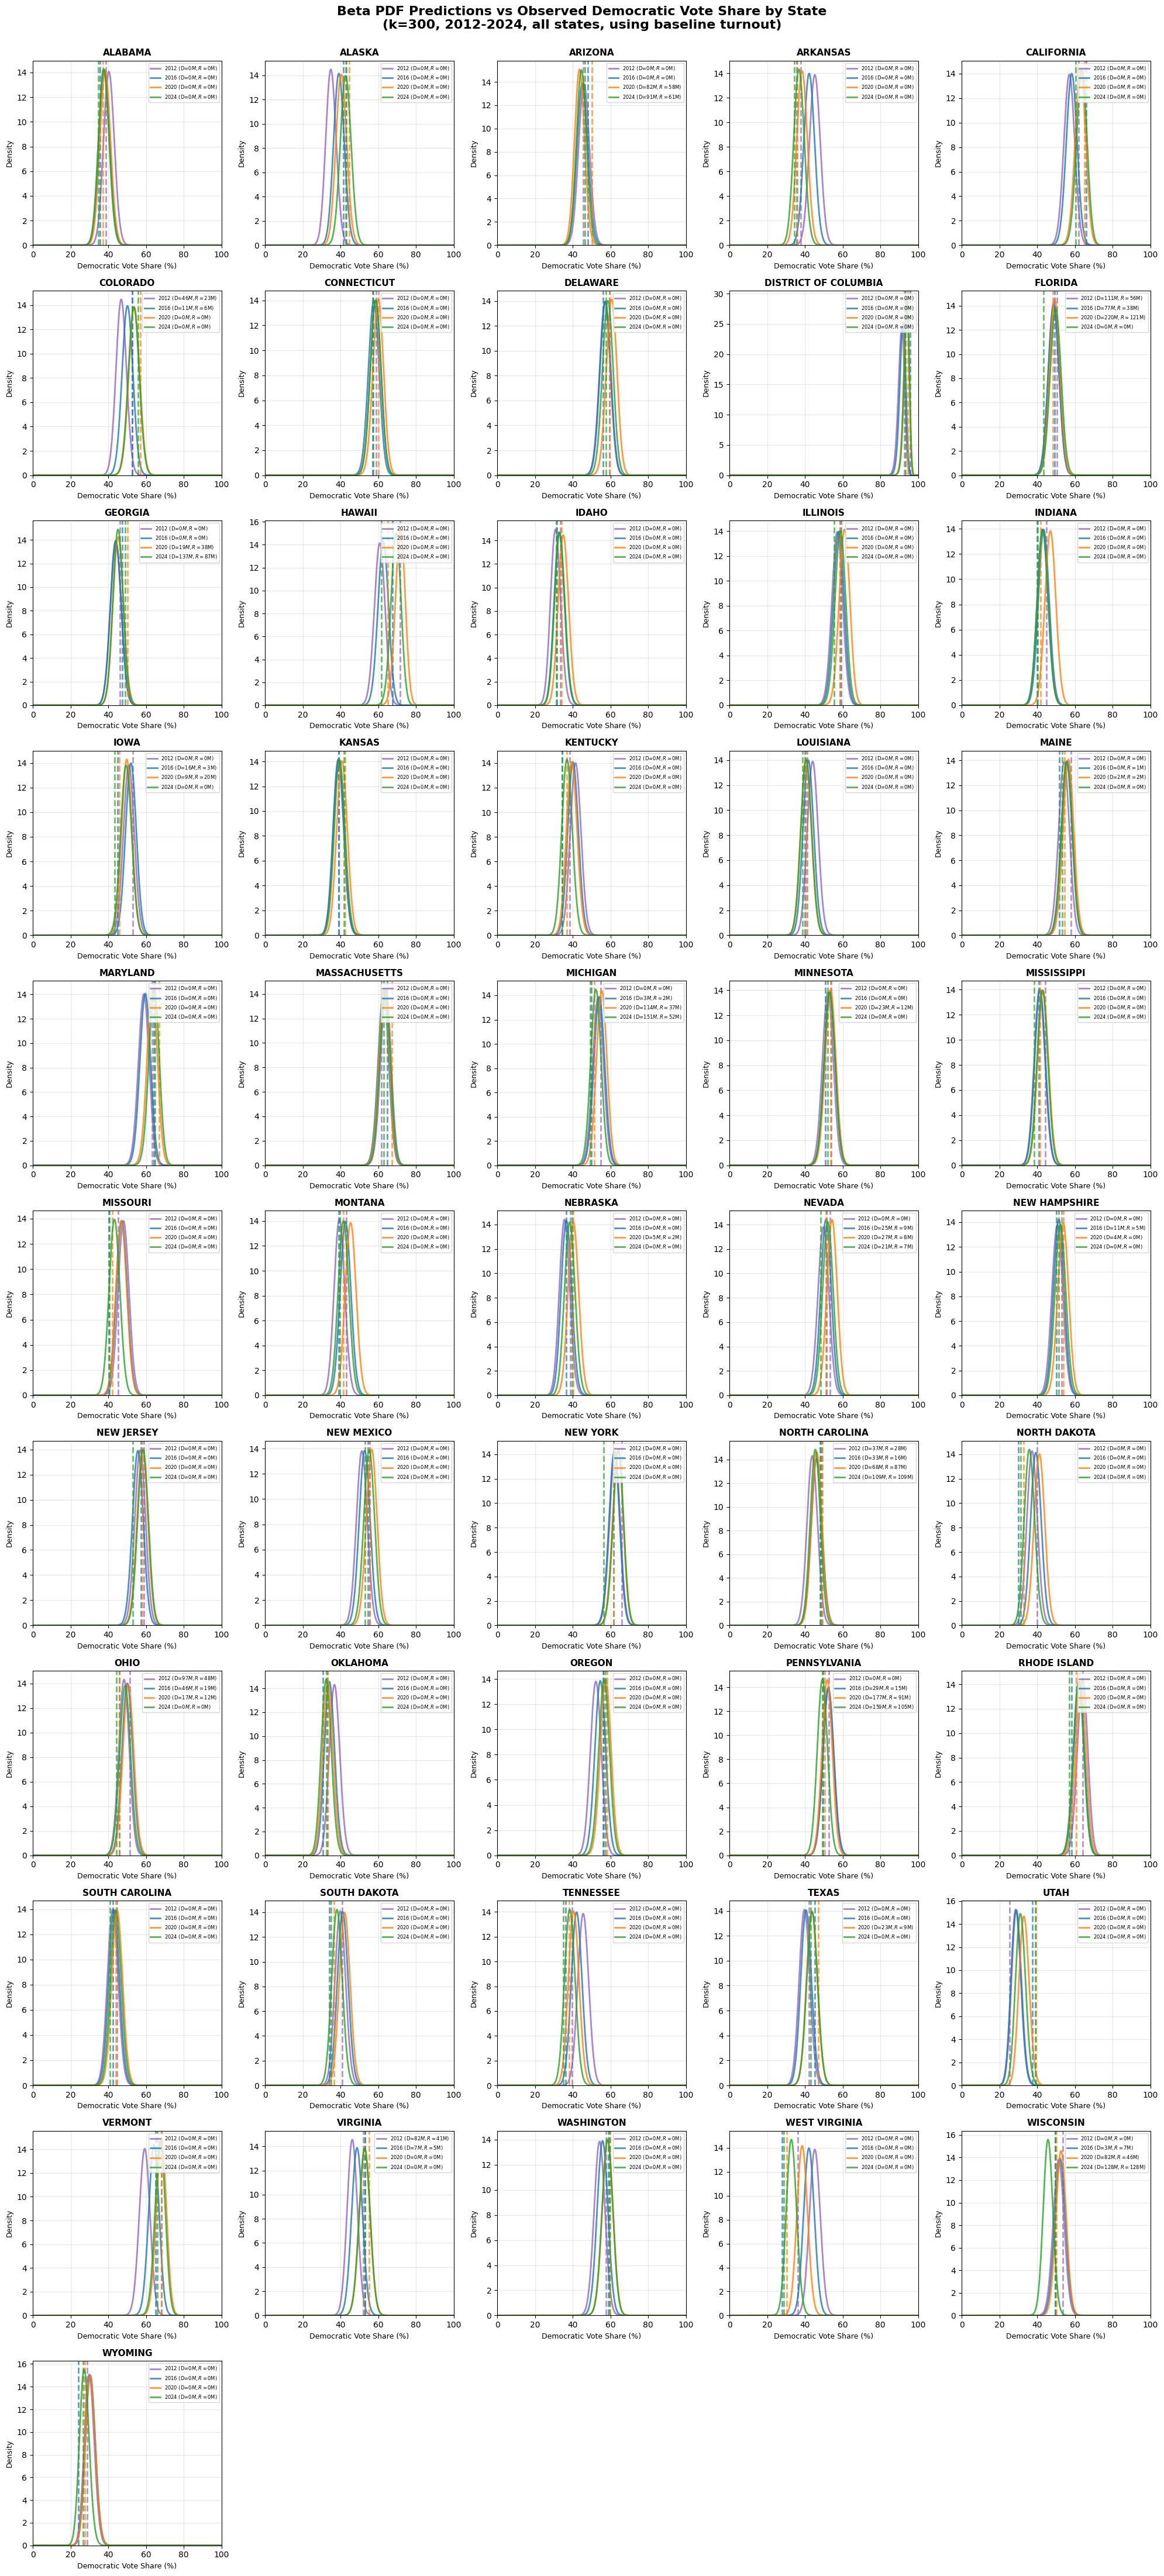


SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016

WYOMING: Baseline Pop=241,309, Baseline=0.306, Actual=0.243


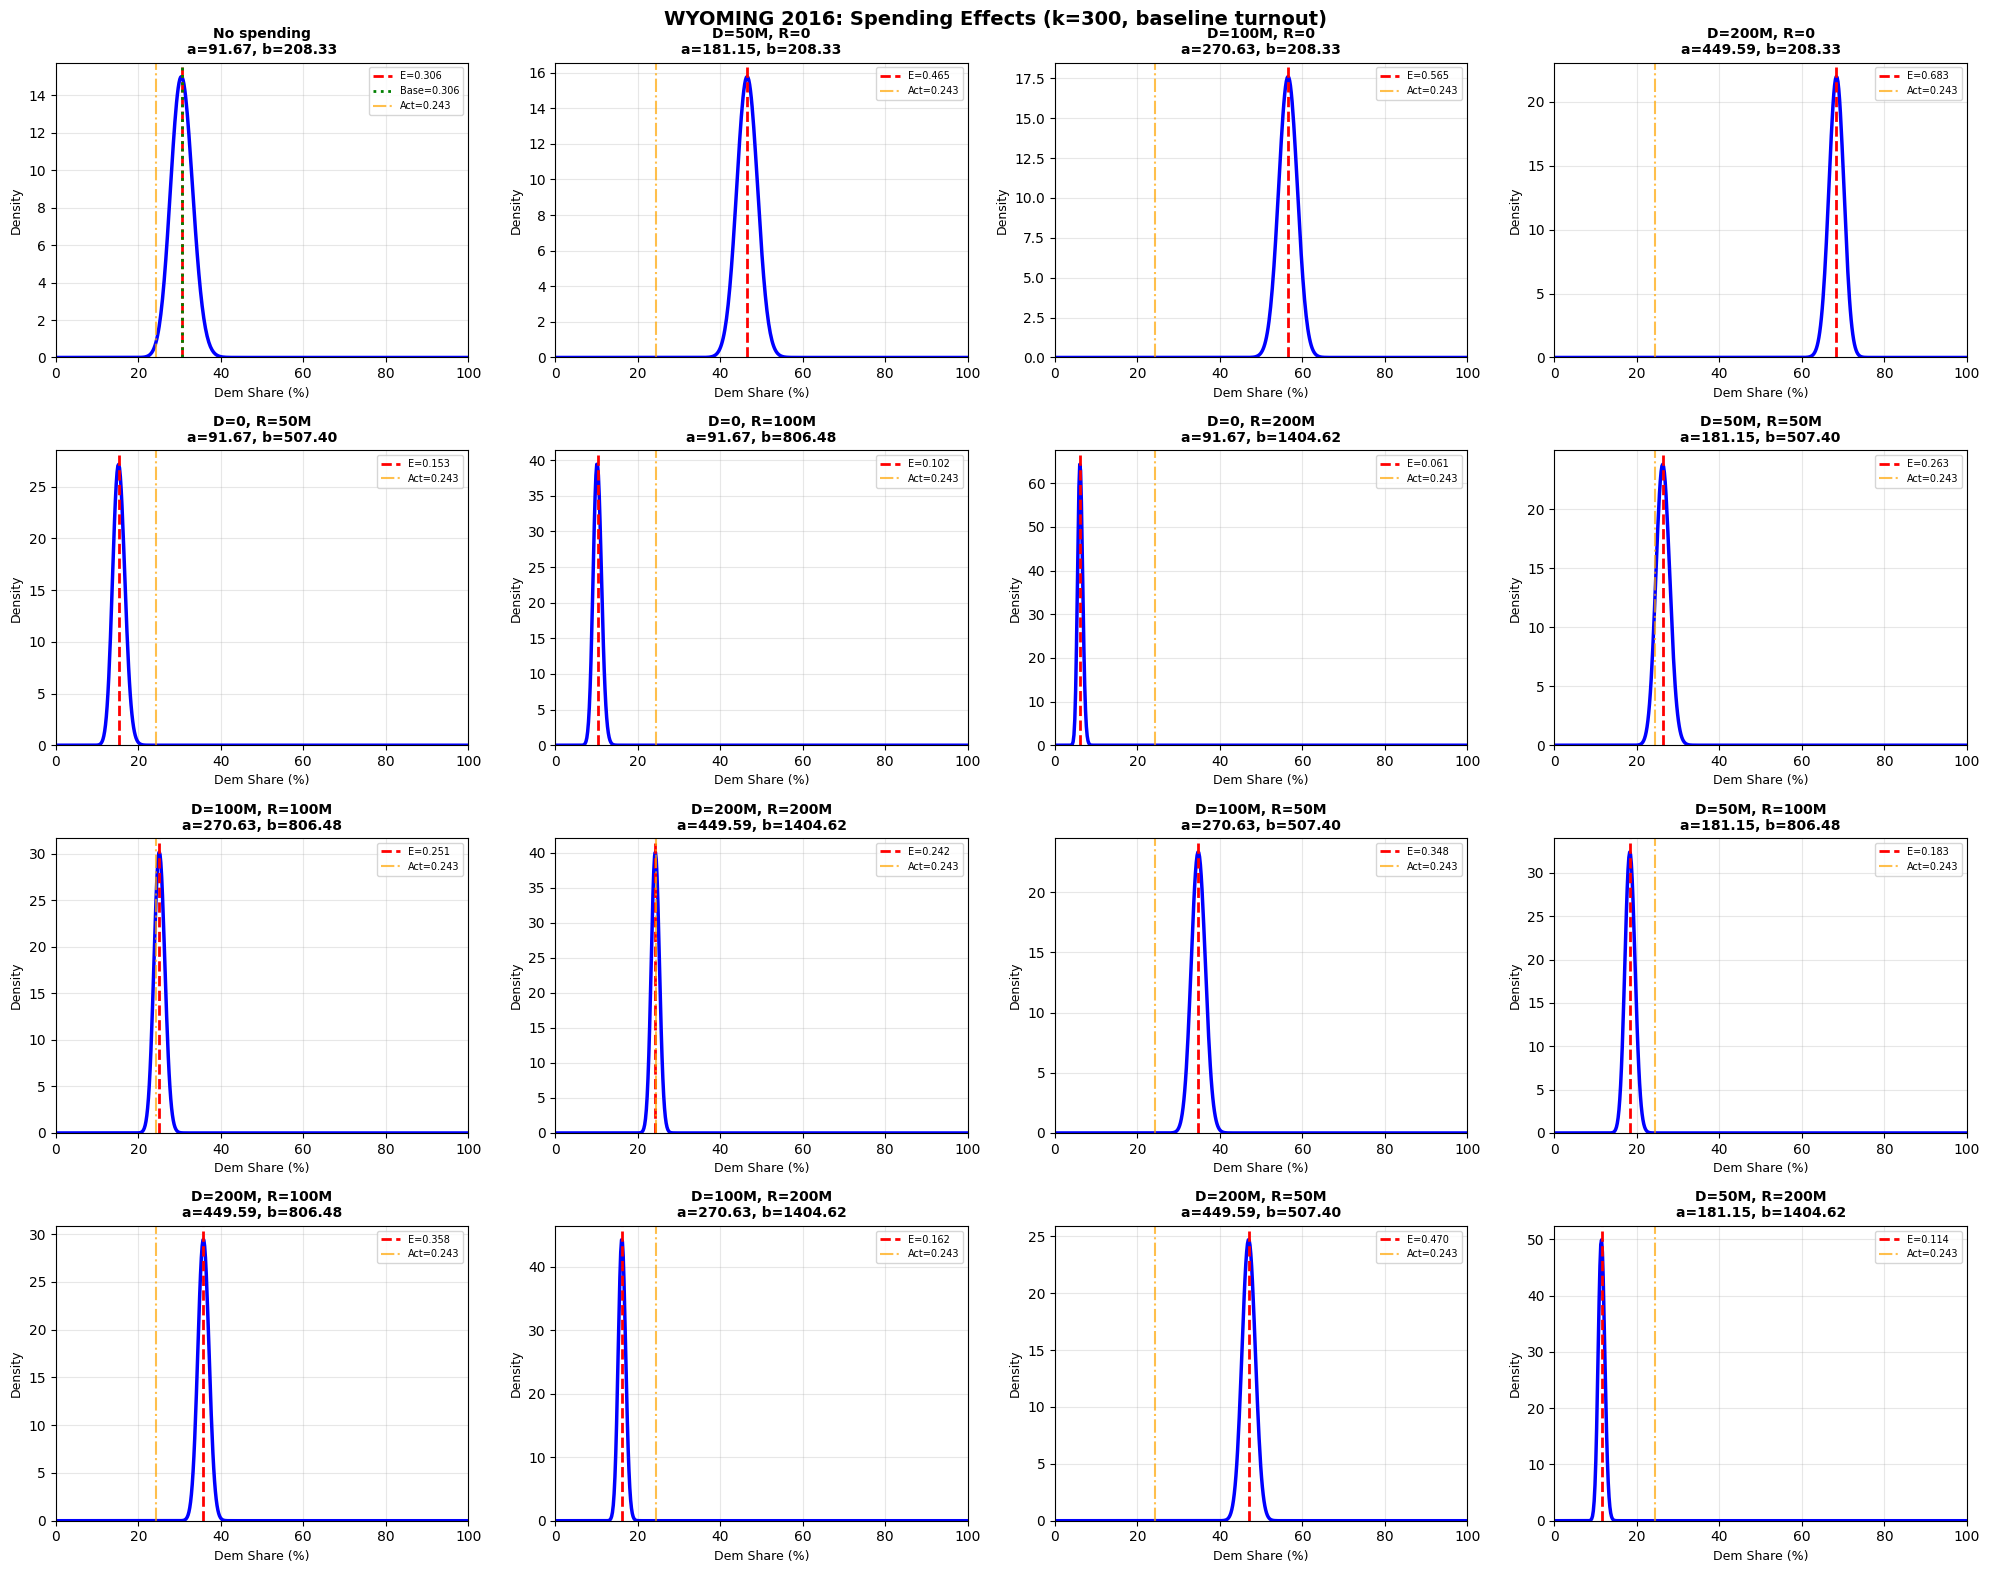


TEXAS: Baseline Pop=7,630,686, Baseline=0.406, Actual=0.453


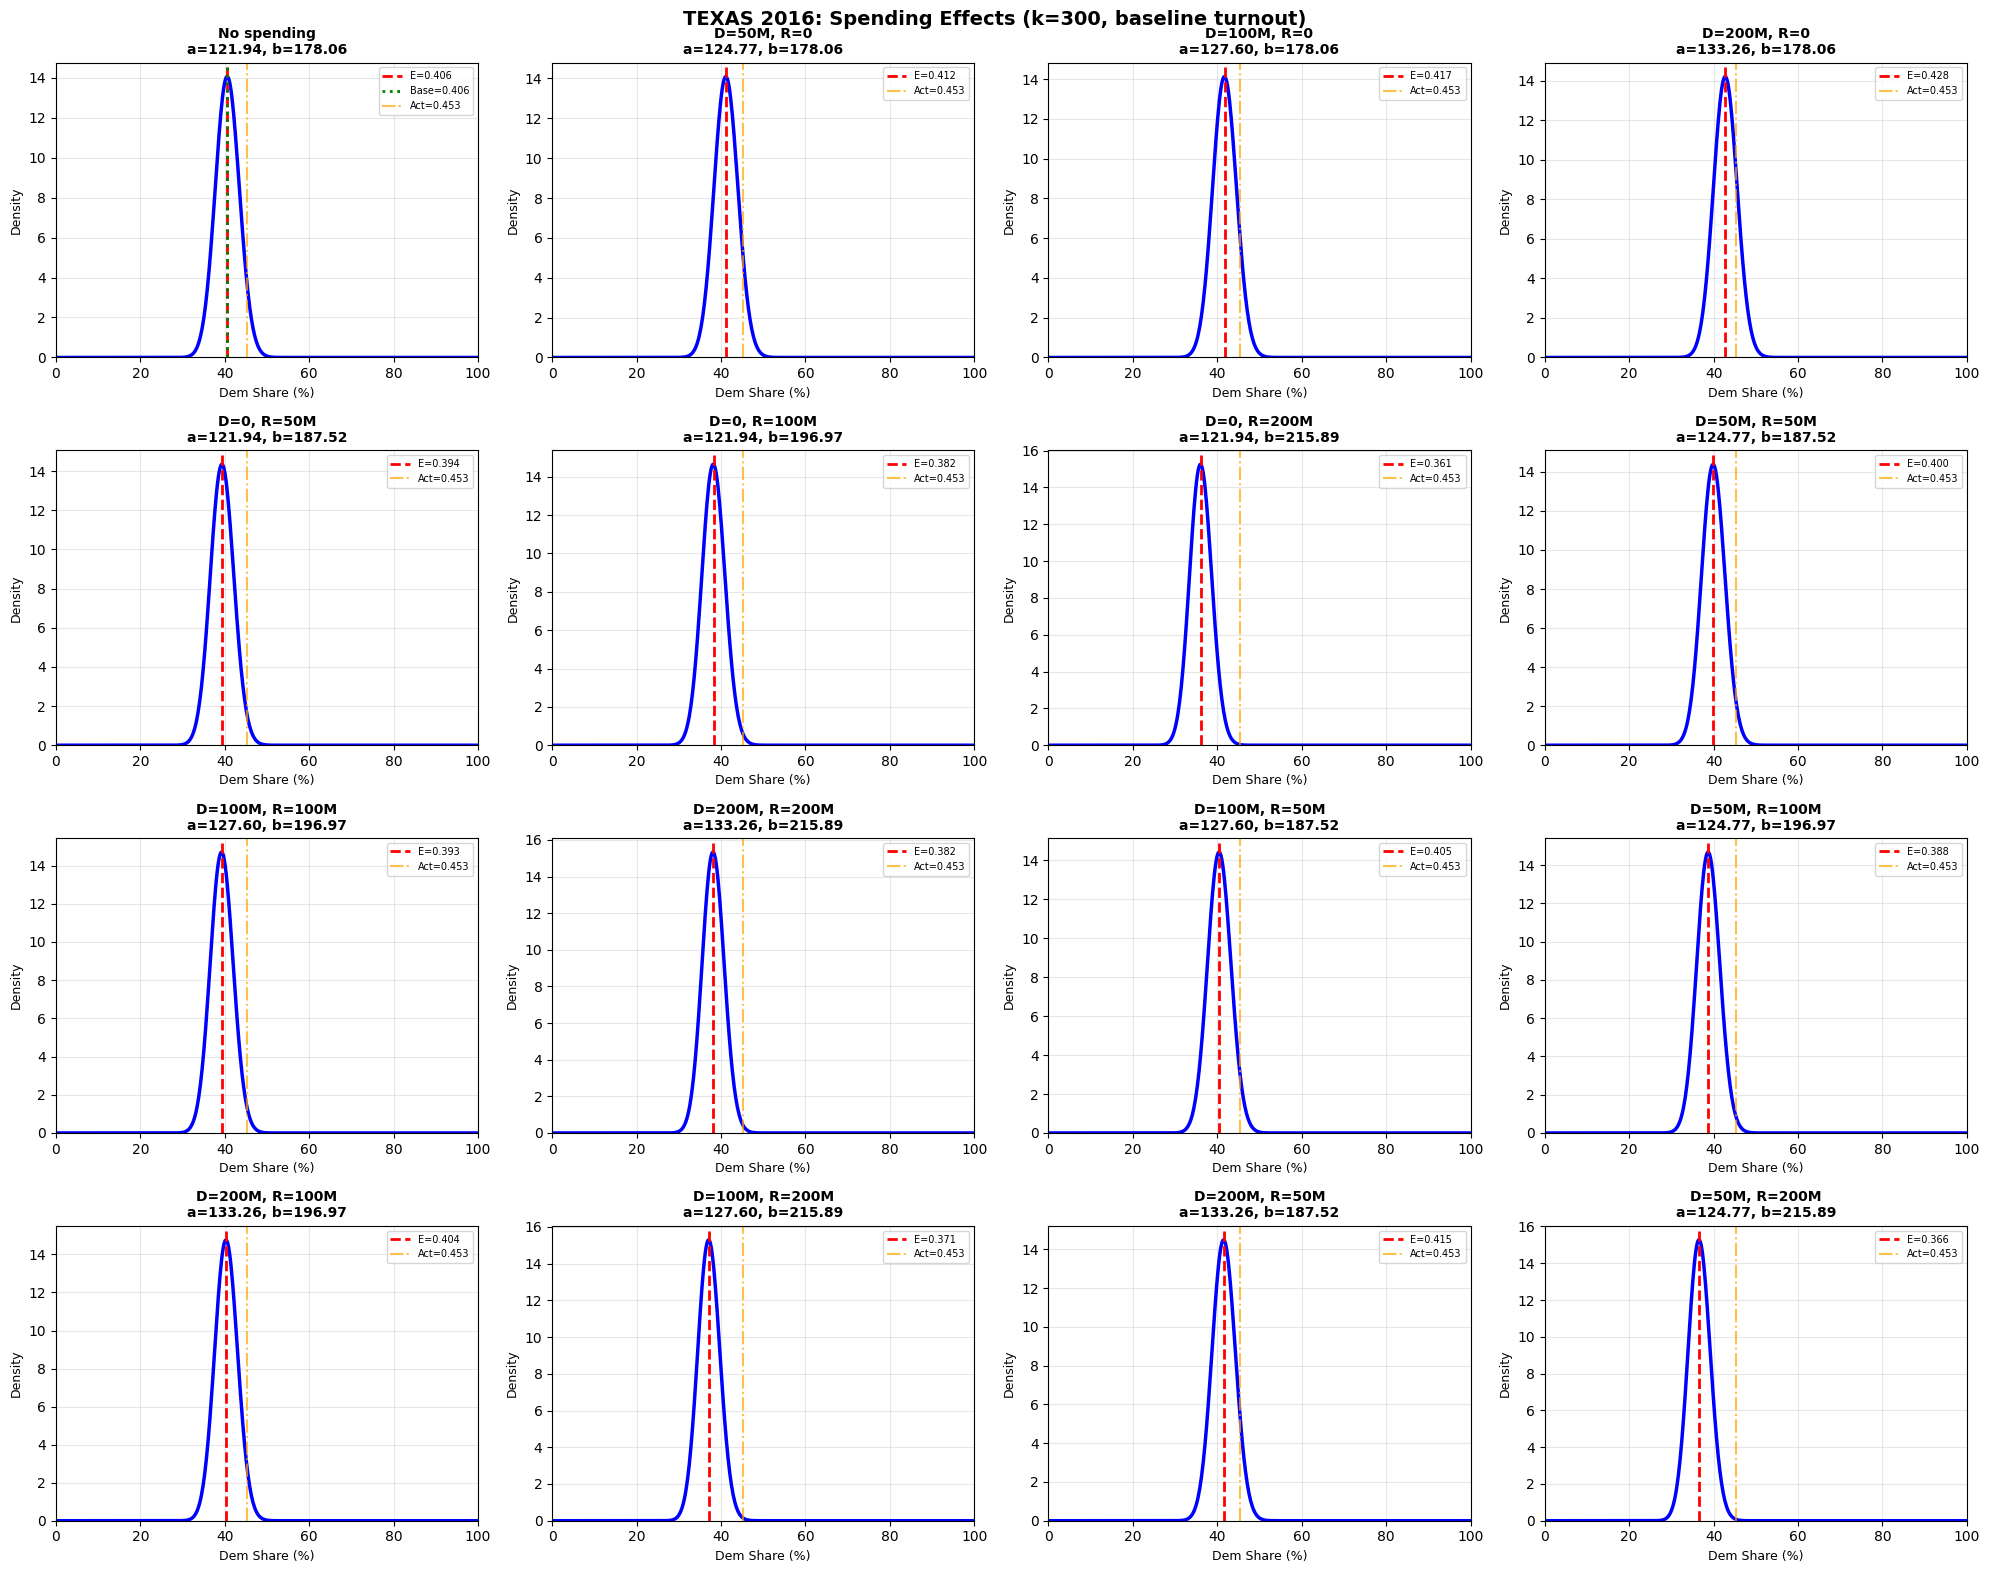


OHIO: Baseline Pop=5,581,252, Baseline=0.503, Actual=0.457


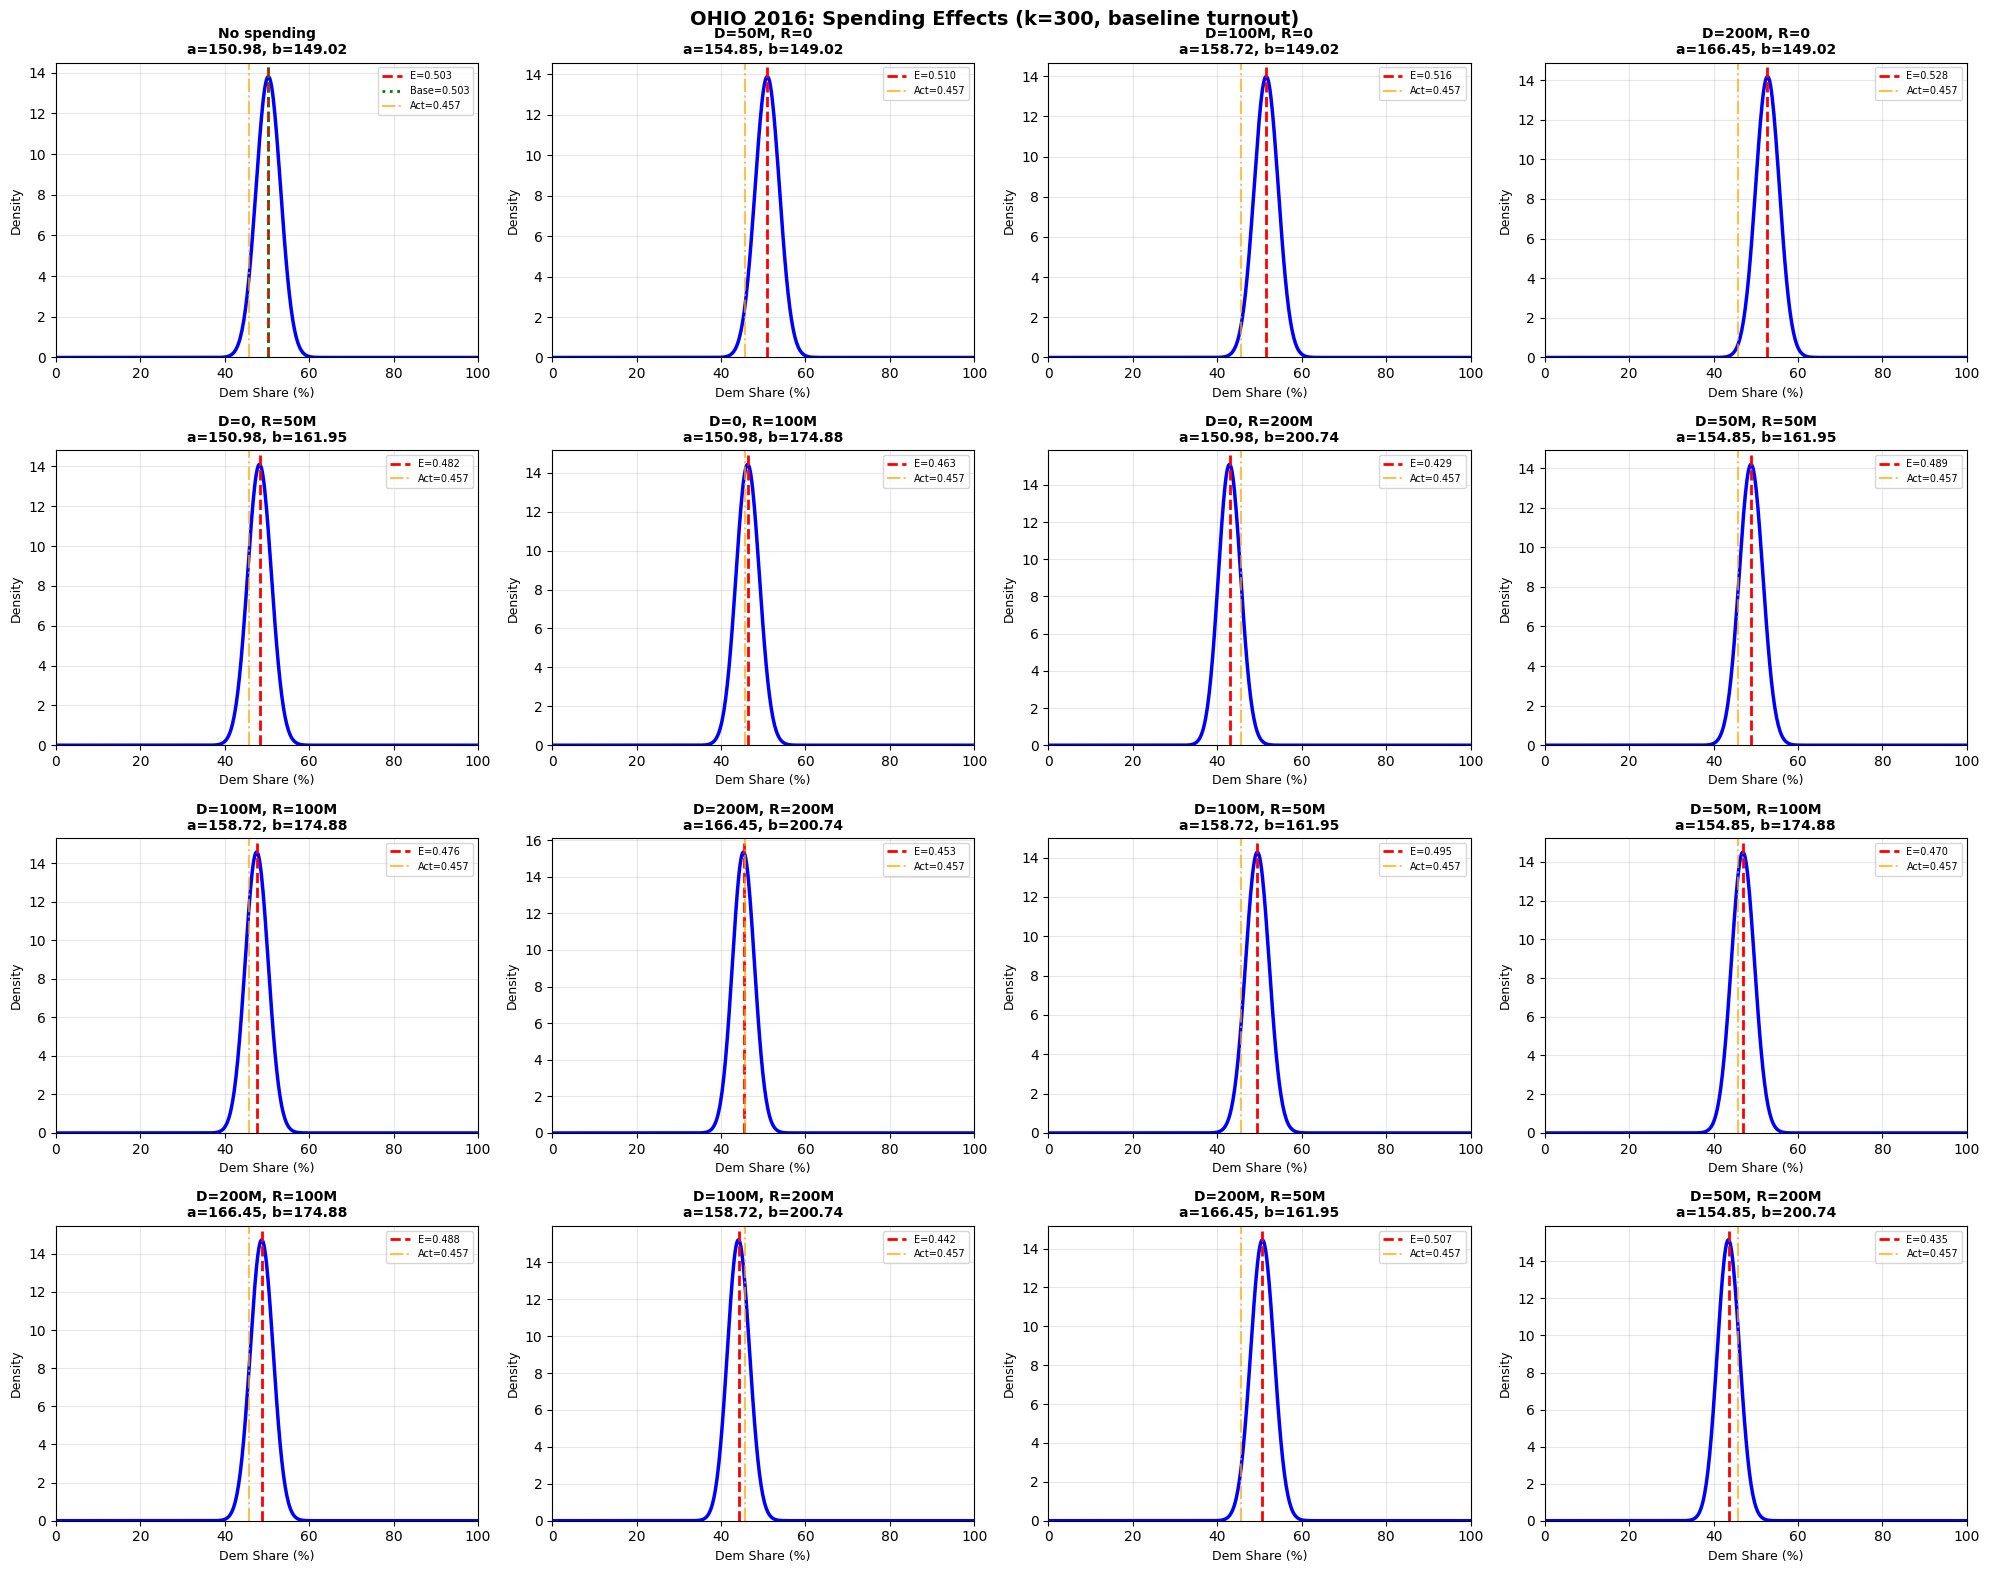


MODEL SUMMARY
Optimal k = 300
Use these fitted parameters for simulation:
  g(D) and h(R) functions with coefficients above
  N = Baseline_total_partisan (weighted avg of past 3 elections)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# --- Calculate Democratic Vote Share by State and Year ---
state_partisan_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()

state_partisan_votes['DEM_SHARE'] = state_partisan_votes['DEMOCRAT'] / (
    state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN'])
state_partisan_votes['total_partisan'] = state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN']
state_partisan_votes = state_partisan_votes.sort_values(['state', 'year']).reset_index(drop=True)

# Calculate weighted 3-year prior Democratic share (baseline partisan lean)
def past_3_inverse_weights(series):
    s = series.shift(1)
    values = np.full(series.shape[0], np.nan)
    weights = np.array([1, 1/2, 1/3])
    for i in range(3, len(s)+1):
        window = s.iloc[i-3:i].values
        if np.isnan(window).any():
            continue
        weighted_avg = np.dot(window, weights) / np.sum(weights)
        values[i-1] = weighted_avg
    return pd.Series(values, index=series.index)

state_partisan_votes['Baseline_DEM_SHARE'] = (
    state_partisan_votes.groupby('state')['DEM_SHARE'].transform(past_3_inverse_weights)
)

# Calculate weighted 3-year prior total partisan votes (baseline turnout)
state_partisan_votes['Baseline_total_partisan'] = (
    state_partisan_votes.groupby('state')['total_partisan'].transform(past_3_inverse_weights)
)

# Standardize state names
state_partisan_votes['state'] = state_partisan_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge with ad spending
combined_data = ad_df.merge(
    state_partisan_votes[['year', 'state', 'total_partisan', 'DEM_SHARE', 'Baseline_DEM_SHARE', 'Baseline_total_partisan']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)

# Filter out Iowa 2016
combined_data = combined_data[~((combined_data['State'] == 'IOWA') & (combined_data['year'] == 2016))]
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'DEM_SHARE', 'total_partisan', 'Baseline_DEM_SHARE', 'Baseline_total_partisan'])

eps = 1e-7

# === Define model functions ===
def g(D, g1):
    """Democratic spending effect - linear only"""
    return g1 * D

def h(R, h1):
    """Republican spending effect - linear only"""
    return h1 * R

def neg_log_likelihood(params, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed):
    """Negative log-likelihood for optimization - now only linear basis functions"""
    g1, h1 = params

    if np.any(np.array([g1, h1]) < 0):
        return 1e12

    g_vals = g(D_spending, g1)
    h_vals = h(R_spending, h1)

    a_vals = (1.0 / baseline_total_partisan) * g_vals + p_D_fixed
    b_vals = (1.0 / baseline_total_partisan) * h_vals + p_R_fixed

    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12

    ll = np.sum(beta.logpdf(dem_share_clipped, a_vals, b_vals))
    return -ll

# Initial parameters and bounds (linear only!)
initial_params = np.array([5e5, 5e5])
bounds = [
    (0, None),  # g1
    (0, None),  # h1
]

# === PARAMETER SEARCH FOR OPTIMAL k_baseline ===
print("\n" + "="*80)
print("SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS")
print("="*80)

k_values = [50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]
results_by_k = []

n_random_starts = 50  # Try 50 different random initializations per k

for k_baseline in k_values:
    print(f"\nTrying k_baseline = {k_baseline}...")

    combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
    combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])

    D_spending = combined_data['D-ad-spending'].values
    R_spending = combined_data['R-ad-spending'].values
    dem_share = combined_data['DEM_SHARE'].values
    baseline_total_partisan = combined_data['Baseline_total_partisan'].values
    p_D_fixed = combined_data['p_D'].values
    p_R_fixed = combined_data['p_R'].values
    dem_share_clipped = np.clip(dem_share, eps, 1 - eps)

    best_nll = np.inf
    best_params_for_k = None
    best_success = False

    # Try multiple random initializations
    for i in range(n_random_starts):
        random_init = np.array([
            np.random.uniform(1e4, 1e7),  # g1
            np.random.uniform(1e4, 1e7),  # h1
        ])

        result_k = minimize(
            lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
            random_init, bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000, 'ftol': 1e-8}
        )

        if result_k.success and result_k.fun < best_nll:
            best_nll = result_k.fun
            best_params_for_k = result_k.x.copy()
            best_success = True

    results_by_k.append({
        'k_baseline': k_baseline,
        'neg_log_likelihood': best_nll,
        'success': best_success,
        'params': best_params_for_k
    })

    print(f"  Best Neg Log-Likelihood: {best_nll:.4f} (from {n_random_starts} random starts)")

# Find best k
results_df = pd.DataFrame(results_by_k)
best_idx = results_df['neg_log_likelihood'].idxmin()
best_k = results_df.loc[best_idx, 'k_baseline']
best_params = results_df.loc[best_idx, 'params']

print("\n" + "="*80)
print("k_baseline SEARCH RESULTS")
print("="*80)
print(results_df[['k_baseline', 'neg_log_likelihood', 'success']].to_string(index=False))
print(f"\nOPTIMAL k_baseline = {best_k}")

# Plot likelihood vs k
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(results_df['k_baseline'], results_df['neg_log_likelihood'], 'o-', lw=2, markersize=8)
ax.axvline(best_k, color='r', linestyle='--', lw=2, label=f'Optimal k = {best_k}')
ax.set_xlabel('k_baseline', fontsize=12)
ax.set_ylabel('Negative Log-Likelihood', fontsize=12)
ax.set_title('Model Fit Quality vs Baseline Strength Parameter', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot spending effect curves for different k values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

D_range_viz = np.linspace(0, 300, 200)
R_range_viz = np.linspace(0, 300, 200)

for i, row in results_df.iterrows():
    if row['success'] and row['params'] is not None:
        k_val = row['k_baseline']
        params = row['params']
        g1 = params[0]
        h1 = params[1]

        g_curve = g(D_range_viz, g1)
        h_curve = h(R_range_viz, h1)

        alpha = 0.3 if k_val != best_k else 1.0
        lw = 1.5 if k_val != best_k else 3.0
        label = f'k={k_val}' + (' (BEST)' if k_val == best_k else '')

        axes[0].plot(D_range_viz, g_curve, alpha=alpha, lw=lw, label=label)
        axes[1].plot(R_range_viz, h_curve, alpha=alpha, lw=lw, label=label, color=f'C{i}')

axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=11)
axes[0].set_ylabel('g(D)', fontsize=11)
axes[0].set_title('Democratic Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=11)
axes[1].set_ylabel('h(R)', fontsize=11)
axes[1].set_title('Republican Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === FIT FINAL MODEL WITH OPTIMAL k ===
k_baseline = best_k
combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])

D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
dem_share = combined_data['DEM_SHARE'].values
baseline_total_partisan = combined_data['Baseline_total_partisan'].values
p_D_fixed = combined_data['p_D'].values
p_R_fixed = combined_data['p_R'].values
dem_share_clipped = np.clip(dem_share, eps, 1 - eps)

print("\n" + "="*80)
print("FINAL FIT WITH OPTIMAL k")
print("="*80)

result = minimize(
    lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
    best_params, bounds=bounds, method='L-BFGS-B', options={'maxiter': 2000, 'ftol': 1e-9}
)

g1_opt = result.x[0]
h1_opt = result.x[1]

print(f"\nDemocratic spending effect g(D):")
print(f"  g1   = {g1_opt}")

print(f"\nRepublican spending effect h(R):")
print(f"  h1   = {h1_opt}")

print(f"\nOptimal k_baseline = {k_baseline}")
print(f"Final neg log-likelihood: {result.fun:.4f}")

# Calculate fitted values for diagnostics
g_vals_fitted = g(D_spending, g1_opt)
h_vals_fitted = h(R_spending, h1_opt)
a_fitted = (1.0 / baseline_total_partisan) * g_vals_fitted + p_D_fixed
b_fitted = (1.0 / baseline_total_partisan) * h_vals_fitted + p_R_fixed
predicted_share = a_fitted / (a_fitted + b_fitted)

residuals = dem_share - predicted_share
print(f"\nModel fit:")
print(f"  Mean absolute error: {np.mean(np.abs(residuals)):.4f}")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")

# === PLOT FINAL OPTIMAL g(D) AND h(R) FUNCTIONS ===
print("\n" + "="*80)
print("PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

D_range_final = np.linspace(0, 300, 500)
R_range_final = np.linspace(0, 300, 500)

g_final = g(D_range_final, g1_opt)
h_final = h(R_range_final, h1_opt)

axes[0].plot(D_range_final, g_final, 'b-', lw=3)
axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=12)
axes[0].set_ylabel('g(D)', fontsize=12)
axes[0].set_title(f'Optimal Democratic Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)

g_text = (f"g(D) = {g1_opt:.2e}·D")
axes[0].text(0.05, 0.95, g_text, transform=axes[0].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].plot(R_range_final, h_final, 'r-', lw=3)
axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=12)
axes[1].set_ylabel('h(R)', fontsize=12)
axes[1].set_title(f'Optimal Republican Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)

h_text = (f"h(R) = {h1_opt:.2e}·R")
axes[1].text(0.05, 0.95, h_text, transform=axes[1].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# === PLOT ALL 51 STATE DISTRIBUTIONS FOR 2012-2024 ===
print("\n" + "="*80)
print("GENERATING STATE-BY-STATE BETA DISTRIBUTIONS")
print("="*80)

# Prepare all states data
all_state_votes = state_partisan_votes.copy()
all_state_votes['p_D'] = k_baseline * all_state_votes['Baseline_DEM_SHARE']
all_state_votes['p_R'] = k_baseline * (1 - all_state_votes['Baseline_DEM_SHARE'])

all_states_data = all_state_votes.merge(
    ad_df[['year', 'State', 'D-ad-spending', 'R-ad-spending']],
    left_on=['year', 'state'], right_on=['year', 'State'], how='left'
)
all_states_data['D-ad-spending'] = all_states_data['D-ad-spending'].fillna(0)
all_states_data['R-ad-spending'] = all_states_data['R-ad-spending'].fillna(0)

years_to_plot = [2012, 2016, 2020, 2024]
plot_data = all_states_data[all_states_data['year'].isin(years_to_plot)].copy()
plot_data = plot_data.dropna(subset=['p_D', 'p_R', 'Baseline_total_partisan'])

# Calculate a and b for each state-year using BASELINE turnout
D_plot = plot_data['D-ad-spending'].values
R_plot = plot_data['R-ad-spending'].values
N_plot = plot_data['Baseline_total_partisan'].values
p_D_plot = plot_data['p_D'].values
p_R_plot = plot_data['p_R'].values

g_plot = g(D_plot, g1_opt)
h_plot = h(R_plot, h1_opt)

plot_data['a'] = (1.0 / N_plot) * g_plot + p_D_plot
plot_data['b'] = (1.0 / N_plot) * h_plot + p_R_plot

# Create state plots
unique_plot_states = sorted(plot_data['state'].unique())
n_plot_states = len(unique_plot_states)
n_cols = 5
n_rows = (n_plot_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

x_range = np.linspace(0, 1, 500)
year_colors = {2012: '#9467bd', 2016: '#1f77b4', 2020: '#ff7f0e', 2024: '#2ca02c'}

for idx, state in enumerate(unique_plot_states):
    ax = axes[idx]
    state_entries = plot_data[plot_data['state'] == state]

    for _, row in state_entries.iterrows():
        a_val = row['a']
        b_val = row['b']
        dem_share_actual = row['DEM_SHARE']
        year = int(row['year'])
        d_spend = row['D-ad-spending']
        r_spend = row['R-ad-spending']
        color = year_colors.get(year, 'gray')

        pdf_vals = beta.pdf(x_range, a_val, b_val)

        ax.plot(x_range * 100, pdf_vals, linewidth=2, color=color,
                label=f'{year} (D=${d_spend:.0f}M, R=${r_spend:.0f}M)', alpha=0.8)

        ax.axvline(x=dem_share_actual * 100, linestyle='--', linewidth=2,
                   alpha=0.7, color=color)

    ax.set_xlim(0, 100)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Democratic Vote Share (%)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.set_title(f'{state}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=6, loc='upper right')
    ax.grid(True, alpha=0.3)

for idx in range(n_plot_states, len(axes)):
    axes[idx].axis('off')

plt.suptitle(
    f'Beta PDF Predictions vs Observed Democratic Vote Share by State\n'
    f'(k={k_baseline}, 2012-2024, all states, using baseline turnout)',
    fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# === SENSITIVITY ANALYSIS FOR WYOMING, TEXAS, OHIO 2016 ===
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016")
print("="*80)

test_scenarios = [
    (0, 0, "No spending"), (50, 0, "D=50M, R=0"), (100, 0, "D=100M, R=0"), (200, 0, "D=200M, R=0"),
    (0, 50, "D=0, R=50M"), (0, 100, "D=0, R=100M"), (0, 200, "D=0, R=200M"),
    (50, 50, "D=50M, R=50M"), (100, 100, "D=100M, R=100M"), (200, 200, "D=200M, R=200M"),
    (100, 50, "D=100M, R=50M"), (50, 100, "D=50M, R=100M"), (200, 100, "D=200M, R=100M"),
    (100, 200, "D=100M, R=200M"), (200, 50, "D=200M, R=50M"), (50, 200, "D=50M, R=200M"),
]

for state_name in ['WYOMING', 'TEXAS', 'OHIO']:
    state_data = all_states_data[(all_states_data['state'] == state_name) & (all_states_data['year'] == 2016)]

    if len(state_data) == 0:
        print(f"\n{state_name} 2016 data not found, skipping...")
        continue

    state_row = state_data.iloc[0]
    N_state = state_row['Baseline_total_partisan']
    p_D_state = state_row['p_D']
    p_R_state = state_row['p_R']
    actual_dem_share = state_row['DEM_SHARE']
    baseline_dem_share = state_row['Baseline_DEM_SHARE']

    print(f"\n{state_name}: Baseline Pop={N_state:,.0f}, Baseline={baseline_dem_share:.3f}, Actual={actual_dem_share:.3f}")

    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.flatten()
    x_range = np.linspace(0, 1, 500)

    for idx, (D_test, R_test, label) in enumerate(test_scenarios):
        ax = axes[idx]

        g_val = g(D_test, g1_opt)
        h_val = h(R_test, h1_opt)

        a_test = (1.0 / N_state) * g_val + p_D_state
        b_test = (1.0 / N_state) * h_val + p_R_state
        expected_share = a_test / (a_test + b_test)

        pdf_vals = beta.pdf(x_range, a_test, b_test)
        ax.plot(x_range * 100, pdf_vals, 'b-', lw=2.5)
        ax.axvline(expected_share * 100, color='r', linestyle='--', lw=2, label=f'E={expected_share:.3f}')

        if idx == 0:
            ax.axvline(baseline_dem_share * 100, color='g', linestyle=':', lw=2, label=f'Base={baseline_dem_share:.3f}')

        ax.axvline(actual_dem_share * 100, color='orange', linestyle='-.', lw=1.5, alpha=0.7, label=f'Act={actual_dem_share:.3f}')

        ax.set_xlim(0, 100)
        ax.set_ylim(bottom=0)
        ax.set_xlabel('Dem Share (%)', fontsize=9)
        ax.set_ylabel('Density', fontsize=9)
        ax.set_title(f'{label}\na={a_test:.2f}, b={b_test:.2f}', fontsize=10, fontweight='bold')
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'{state_name} 2016: Spending Effects (k={k_baseline}, baseline turnout)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(f"Optimal k = {k_baseline}")
print("Use these fitted parameters for simulation:")
print(f"  g(D) and h(R) functions with coefficients above")
print(f"  N = Baseline_total_partisan (weighted avg of past 3 elections)")
print("="*80)

In [8]:
# === PRINT FINAL PARAMETERS IN LATEX FORMAT ===
print("\n" + "="*80)
print("FINAL PARAMETERS")
print("="*80)

from IPython.display import display, Math, Markdown

display(Markdown("### Fitted Model Parameters"))

display(Markdown(r"**Optimal Baseline Strength:**"))
display(Math(f"k = {k_baseline}"))

display(Markdown(r"**Democratic Spending Effect:**"))
display(Math(f"g(D) = {g1_opt:.6e} \\cdot D"))

display(Markdown(r"**Republican Spending Effect:**"))
display(Math(f"h(R) = {h1_opt:.6e} \\cdot R"))

display(Markdown(r"**Model Performance:**"))
display(Math(f"\\text{{Negative Log-Likelihood}} = {result.fun:.4f}"))
display(Math(f"\\text{{Mean Absolute Error}} = {np.mean(np.abs(residuals)):.4f}"))
display(Math(f"\\text{{RMSE}} = {np.sqrt(np.mean(residuals**2)):.4f}"))

print("\n" + "="*80)


FINAL PARAMETERS


### Fitted Model Parameters

**Optimal Baseline Strength:**

<IPython.core.display.Math object>

**Democratic Spending Effect:**

<IPython.core.display.Math object>

**Republican Spending Effect:**

<IPython.core.display.Math object>

**Model Performance:**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>